## Error Analysis

**Author:** Shaun Khoo  
**Date:** 4 Jan 2022  
**Context:** Model is performing decently, but need to identify where the model is struggling and see what we can do to improve performance  
**Objective:** Identify where the model is doing worse in, hypothesize why, and think of what we can do to improve this     

#### A) Importing libaries and data

In [63]:
import pandas as pd
import numpy as np
import pickle

In [3]:
import os
os.chdir('..')

In [216]:
test = pd.read_csv('Data/Train/MRSD_Validation.csv')
test['Predicted_SSOC_2020'] = test['Predicted_SSOC_2020'].astype('str')
with open('mrsd_val.pickle', 'rb') as handle:
    test_predictions = pickle.load(handle)

In [217]:
test

,MCF_Job_Ad_ID,title,description,Predicted_SSOC_2020
0,MCF-2020-0000390,Part Timers x 4,<p>Vacancy: 4 x Part time Catering staff for C...,51312
1,MCF-2020-0000734,Character Artist,<p>The Character Artist will be responsible fo...,21662
2,MCF-2020-0000835,Musician- Cello,<p><strong>Job Description</strong></p>\n<p><b...,26521
3,MCF-2020-0001115,Despatch Rider (3 months Contract),"<p>To collect and deliver mails, packages and ...",96299
4,MCF-2020-0001583,BIM Modeller,<p>As a BIM modeller at RoviSys you will get e...,21661
...,...,...,...,...
487,MCF-2020-0265242,Electro-Plater,"<ul>\n <li>Perform plating bath, equipment ma...",81240
488,MCF-2020-0265572,BIM MODELLER,<p>• Ensure 3D shop drawings produced are full...,21661
489,MCF-2020-0265654,"Temp Staff (Admin Assistant), 3 months, S$9.00...",<p>Jobscope&nbsp;</p>\n<p>•\tSupport for grant...,41101
490,MCF-2020-0265751,DRAFTING,<ul>\n <li>Minimum of 3 year experience in in...,31181


In [218]:
df_output = []

for test_prediction in test_predictions:
    
    row_output = {}
    
    row_output['SSOC_4D_Top_Pred'] = test_prediction['SSOC_4D']['predicted_ssoc'][0]
    row_output['SSOC_4D_Top_5_Preds'] = test_prediction['SSOC_4D']['predicted_ssoc']
    row_output['SSOC_4D_Top_5_Preds_Correct'] = test_prediction['SSOC_4D']['accurate_prediction']

    row_output['SSOC_5D_Top_Pred'] = test_prediction['SSOC_5D']['predicted_ssoc'][0]
    row_output['SSOC_5D_Top_10_Preds'] = test_prediction['SSOC_5D']['predicted_ssoc']
    row_output['SSOC_5D_Top_10_Preds_Correct'] = test_prediction['SSOC_5D']['accurate_prediction']

    df_output.append(row_output)
    

In [219]:
test_enhanced = pd.concat([test, pd.DataFrame(df_output)], axis = 1)
test_enhanced['SSOC_4D_Top_Pred_Correct'] = test_enhanced['Predicted_SSOC_2020'].str.slice(0, 4) == test_enhanced['SSOC_4D_Top_Pred']
test_enhanced['SSOC_5D_Top_Pred_Correct'] = test_enhanced['Predicted_SSOC_2020'] == test_enhanced['SSOC_5D_Top_Pred']
test_enhanced['SSOC_2D'] = test_enhanced['Predicted_SSOC_2020'].str.slice(0, 2)

In [220]:
test_enhanced['SSOC_5D_Top_5_Preds_Correct'] = [ssoc in preds[0:5] for ssoc, preds in zip(test_enhanced['Predicted_SSOC_2020'], test_enhanced['SSOC_5D_Top_10_Preds'])]

In [223]:
test_enhanced['SSOC_5D_Top_Pred_Correct'].value_counts(normalize=True)

False    0.74187
True     0.25813
Name: SSOC_5D_Top_Pred_Correct, dtype: float64

In [226]:
SSOC_2D_error_analysis = test_enhanced.groupby('Predicted_SSOC_2020').agg(
    SSOC_5D_Correct_2DLevel = pd.NamedAgg(column = "SSOC_5D_Top_10_Preds_Correct", aggfunc = "sum"),
    Count = pd.NamedAgg(column = "SSOC_5D_Top_Pred_Correct", aggfunc = "count")
).reset_index()
SSOC_2D_error_analysis['Accuracy'] = round(SSOC_2D_error_analysis['SSOC_5D_Correct_2DLevel']/SSOC_2D_error_analysis['Count']*100, 1)

13: Production and specialised services managers  
26: Legal, social, religious, cultural professionals  
31: Engineering Associate Professionals  
32: Health Associate Professionals  
44: Other clerical support workers  
53: Personal care workers  
54: Protective service workers  
74: Electrical and electronic trades workers  
75: Food processing, woodworking, craft trades workers  
81: Plant machinery operators  
82: Assemblers and quality checkers  
91: Cleaners and helpers  
92: Agriculture and fishery workers  
96: Waste collection, recycling workers  

In [176]:
test[test['Predicted_SSOC_2020'] == '31122']

,MCF_Job_Ad_ID,Predicted_SSOC_2020,title,description
1005,MCF-2021-0234416,31122,Building Services Technician,Assist in developing scope of work for the pro...
1371,MCF-2021-0030852,31122,Technician [Building / Facilities / Woodlands]...,Job scopes: Building general maintenance work....
1382,MCF-2020-0345319,31122,Technician (Building),Roles & Responsibilities. Responsibilities: Ca...
1568,MCF-2021-0025954,31122,Technician / Senior Technician (Building & Fac...,Job Descriptions: Must have knowledge in comme...
1907,MCF-2021-0065737,31122,1723T-FACILITY TECHNICIANS (BUILDING & MAINTEN...,Woodlands Attractive Salary Career Progression...
2774,MCF-2021-0109042,31122,Building Technician,"Job Descriptions: Carrying out maintenance, re..."


Some observations:  
* Most of the SSOCs with low counts and 0 accuracy are in the 311 3D SSOC (Physical and Engineering Science Technicians)
* Business development executive is predicted more commonly than expected
* Technical sales consultant (24331) is too close to Electrical engineer (21511)
* Financial analyst (24131) is too close to Business consultant (24212)
* QA engineer (25151) is too close to Software developer (25121)
* Actuarial professionals (21239) is too close to Business consultant (24212)
* 

In [151]:
test_enhanced[test['Predicted_SSOC_2020'] == '25220']

,MCF_Job_Ad_ID,Predicted_SSOC_2020,title,description,SSOC_4D_Top_Pred,SSOC_4D_Top_5_Preds,SSOC_4D_Top_5_Preds_Correct,SSOC_5D_Top_Pred,SSOC_5D_Top_10_Preds,SSOC_5D_Top_10_Preds_Correct,SSOC_4D_Top_Pred_Correct,SSOC_5D_Top_Pred_Correct,SSOC_2D
1335,MCF-2021-0158192,25220,Senior / Network Administrator (Ref: 2021-11...,Our next technology can start with You!Each of...,2523,"[2523, 2522, 3512, 2512, 2511]",True,25232,"[25232, 25241, 35123, 25121, 35121, 25211, 252...",False,False,False,25
1997,MCF-2020-0326451,25220,Computer System Administrator,"Job Responsibility: Installation, maintenance ...",3512,"[3512, 3511, 2523, 1330, 2512]",False,35123,"[35123, 25232, 35121, 36100, 35110, 25241, 252...",True,False,False,25
2298,MCF-2021-0185009,25220,IT Executive (System Network Administration),Core function is to support technology related...,2523,"[2523, 2522, 3512, 2512, 2511]",True,25232,"[25232, 35123, 25241, 25121, 35121, 25211, 252...",False,False,False,25
2775,MCF-2021-0152857,25220,System Network Administrator |Boon Keng - JYK,"Perform daily server monitoring, verifying the...",2523,"[2523, 3512, 2512, 2522, 2521]",True,25232,"[25232, 35123, 25241, 25121, 35121, 25211, 252...",False,False,False,25


In [154]:
test_enhanced[test_enhanced['Predicted_SSOC_2020'] == '33211']['SSOC_5D_Top_Pred'].value_counts()

24212    2
33221    1
Name: SSOC_5D_Top_Pred, dtype: int64

In [234]:
test[test['Predicted_SSOC_2020'] == '11203']

,MCF_Job_Ad_ID,title,description,Predicted_SSOC_2020
22,MCF-2020-0012755,Vice President - 19132341,<p>We are seeking Application Development Lead...,11203
202,MCF-2020-0096313,"Head, ServiceNow CoE",<p><strong>About Standard Chartered&nbsp;</str...,11203
412,MCF-2020-0233952,PMO Head,<ul>\n <li>Able to build and control the Prog...,11203


In [239]:
test_enhanced.loc[202,]

MCF_Job_Ad_ID                                                    MCF-2020-0096313
title                                                        Head, ServiceNow CoE
description                     <p><strong>About Standard Chartered&nbsp;</str...
Predicted_SSOC_2020                                                         11203
SSOC_4D_Top_Pred                                                             2421
SSOC_4D_Top_5_Preds                                [2421, 1330, 2423, 1224, 1219]
SSOC_4D_Top_5_Preds_Correct                                                 False
SSOC_5D_Top_Pred                                                            24212
SSOC_5D_Top_10_Preds            [24212, 13302, 35123, 12241, 12112, 24231, 133...
SSOC_5D_Top_10_Preds_Correct                                                False
SSOC_4D_Top_Pred_Correct                                                    False
SSOC_5D_Top_Pred_Correct                                                    False
SSOC_2D         

In [237]:
test.loc[412, 'description']

'<ul>\n  <li>Able to build and control the Programme Management Office (PMO) for the organisation (resources, contracts, finance, delivery plan/schedule, deliverables, delivery quality/compliance, KPI, risk management, change control management, ownership RACI, etc.)</li>\n  <li>Reporting to executive level internal and external (customer) stakeholders</li>\n  <li>Governance: Organize various governance meetings with stake holders and keep track of action items</li>\n  <li>Compliance: Ensure the program team is performing and delivering in compliance with the contract terms &amp; conditions with customer</li>\n  <li>Financial: Maintain financial budget, forecast &amp; actual cash flow financial status update</li>\n  <li>Change: Maintain change control &amp; management process and keep track of all change requests</li>\n  <li>Transition: Maintain transition management process and keep track</li>\n  <li>Communication: Communication management for the program</li>\n  <li>Human Resource: M

In [231]:
num = 100
print(f"Average accuracy: {np.mean(SSOC_2D_error_analysis[SSOC_2D_error_analysis['Count'] < num]['Accuracy'])}")
SSOC_2D_error_analysis[(SSOC_2D_error_analysis['Count'] < num) & (SSOC_2D_error_analysis['Accuracy'] >= 0)].sort_values('Accuracy', ascending = True).head(20)

Average accuracy: 44.710204081632654


,Predicted_SSOC_2020,SSOC_5D_Correct_2DLevel,Count,Accuracy
0,11203,0,3,0.0
129,43129,0,2,0.0
127,42249,0,1,0.0
124,41109,0,3,0.0
123,41102,0,3,0.0
117,35129,0,1,0.0
115,35110,0,1,0.0
109,33492,0,6,0.0
107,33222,0,2,0.0
105,33211,0,1,0.0


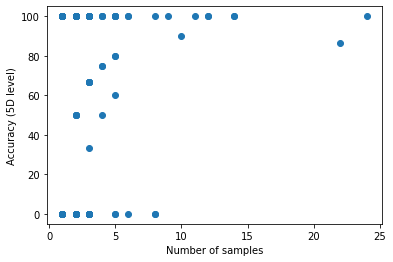

In [227]:
import matplotlib.pyplot as plt
plt.scatter(SSOC_2D_error_analysis['Count'], SSOC_2D_error_analysis['Accuracy'])
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (5D level)')
plt.show()

In [40]:
test_enhanced.groupby('SSOC_2D').apply(lambda x: x['SSOC_4D_Top_Pred_Correct'].sum()/len(x))

SSOC_2D
11    0.333333
12    0.408377
13    0.253012
14    0.616667
21    0.556931
22    0.621951
23    0.600000
24    0.595890
25    0.719907
26    0.339286
31    0.238636
32    0.388889
33    0.473684
34    0.864407
35    0.509091
36    0.707317
41    0.413793
42    0.725806
43    0.586207
44    0.000000
51    0.535714
52    0.304348
53    0.560000
54    0.750000
71    0.536585
72    0.714286
74    0.363636
75    0.545455
81    0.500000
82    0.000000
83    0.407080
91    0.347826
92    1.000000
93    0.714286
94    0.148148
96    0.000000
dtype: float64

In [29]:
test_enhanced['SSOC_4D_Top_Pred_Correct'].value_counts(normalize = True)

True     0.561246
False    0.438754
Name: SSOC_4D_Top_Pred_Correct, dtype: float64

In [88]:
test_enhanced.iloc[6]

MCF_Job_Ad_ID                                                    MCF-2021-0048640
Predicted_SSOC_2020                                                         34222
title                               Martial Arts Instructor (Brazilian Jiu-Jitsu)
description                     Responsibilities: Create safe and holistic pro...
SSOC_4D_Top_Pred                                                             3422
SSOC_4D_Top_5_Preds                                [3422, 3421, 3431, 3439, 3440]
SSOC_4D_Top_5_Preds_Correct                                                  True
SSOC_5D_Top_Pred                                                            34221
SSOC_5D_Top_10_Preds            [34221, 51421, 51491, 42245, 42241, 51411, 519...
SSOC_5D_Top_10_Preds_Correct                                                False
SSOC_4D_Top_Pred_Correct                                                     True
SSOC_5D_Top_Pred_Correct                                                    False
SSOC_2D         